In [8]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from data_loader import FinancialDataLoader
from data_preprocessor import DataPreprocessor
from financial_metrics import FinancialMetrics


In [9]:
# Set plotting style for better visualizations
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

In [10]:
# Initialize our classes
loader = FinancialDataLoader()
preprocessor = DataPreprocessor()
metrics = FinancialMetrics()

In [11]:
# Load data for all assets (2015-2025)
start_date = '2015-01-01'
end_date = '2025-01-31'
assets_data = loader.download_data(start_date=start_date, end_date=end_date)
display(assets_data)

{'TSLA':                                  Open        High         Low       Close  \
 Date                                                                        
 2015-01-02 00:00:00-05:00   14.858000   14.883333   14.217333   14.620667   
 2015-01-05 00:00:00-05:00   14.303333   14.433333   13.810667   14.006000   
 2015-01-06 00:00:00-05:00   14.004000   14.280000   13.614000   14.085333   
 2015-01-07 00:00:00-05:00   14.223333   14.318667   13.985333   14.063333   
 2015-01-08 00:00:00-05:00   14.187333   14.253333   14.000667   14.041333   
 ...                               ...         ...         ...         ...   
 2025-01-24 00:00:00-05:00  414.450012  418.880005  405.779999  406.579987   
 2025-01-27 00:00:00-05:00  394.799988  406.690002  389.000000  397.149994   
 2025-01-28 00:00:00-05:00  396.910004  400.589996  386.500000  398.089996   
 2025-01-29 00:00:00-05:00  395.209991  398.589996  384.480011  389.100006   
 2025-01-30 00:00:00-05:00  410.779999  412.500000  384.

In [13]:
# Process each asset
processed_data = {}
for ticker, data in assets_data.items():
    df = preprocessor.clean_data(data)
    df = preprocessor.calculate_returns(df)
    df = preprocessor.calculate_volatility(df)
    df = preprocessor.detect_outliers(df)
    df = metrics.calculate_rolling_metrics(df)
    processed_data[ticker] = df


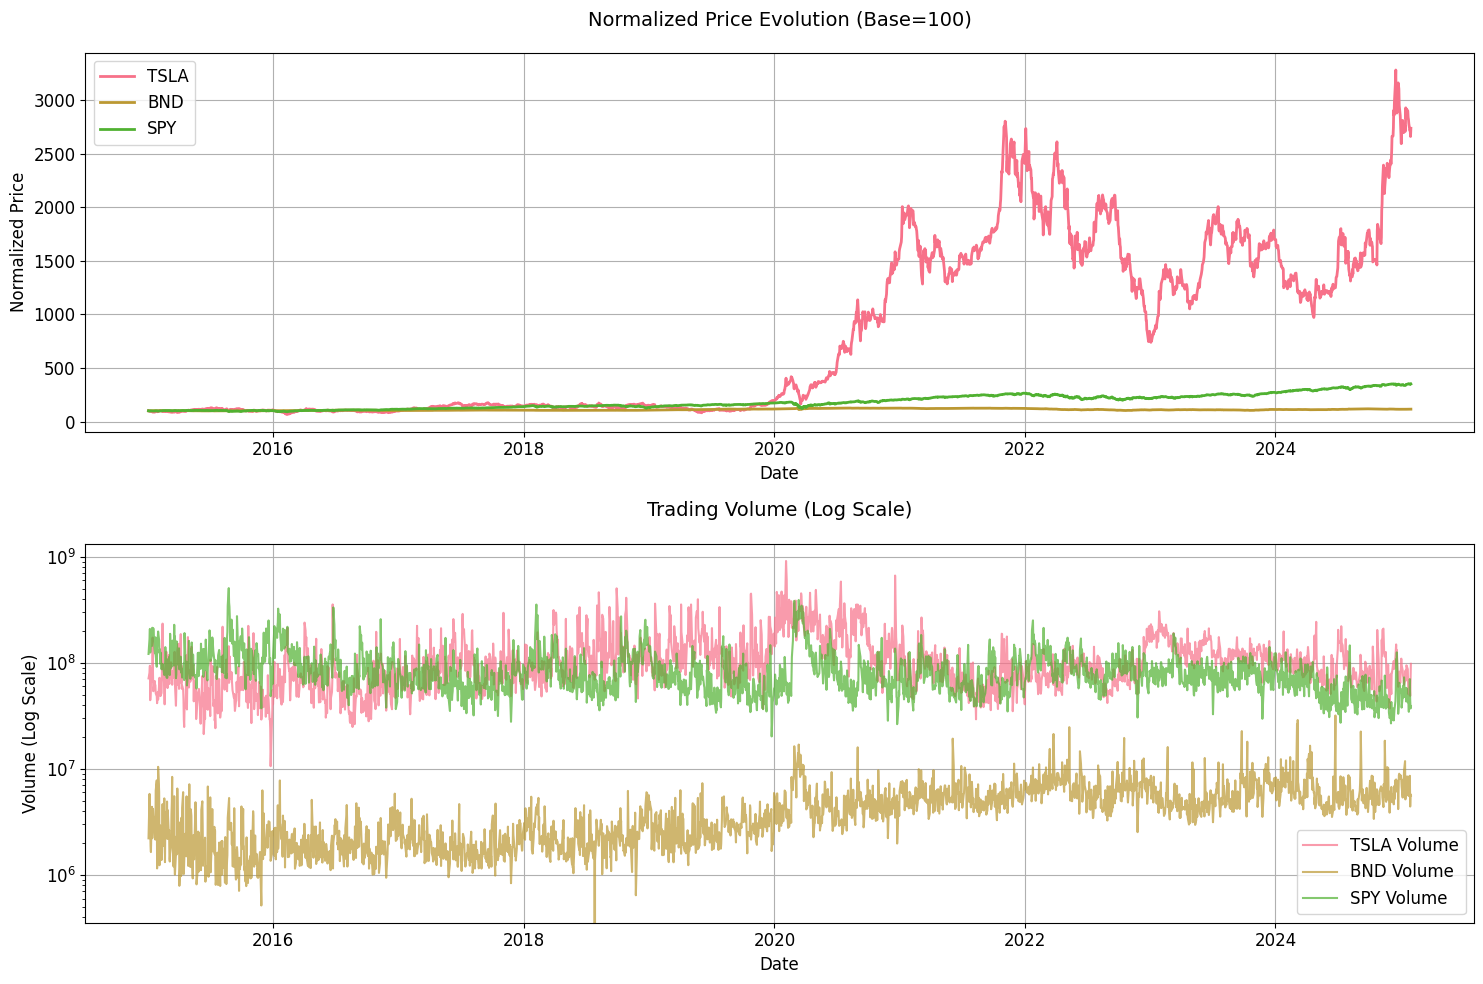

In [14]:
# 1. Price Evolution Analysis
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
for ticker, data in processed_data.items():
    normalized_price = data['Close'] / data['Close'].iloc[0] * 100
    plt.plot(data.index, normalized_price, label=ticker, linewidth=2)
plt.title('Normalized Price Evolution (Base=100)', fontsize=14, pad=20)
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)

# Add volume subplot
plt.subplot(2, 1, 2)
for ticker, data in processed_data.items():
    plt.semilogy(data.index, data['Volume'], label=f'{ticker} Volume', alpha=0.7)
plt.title('Trading Volume (Log Scale)', fontsize=14, pad=20)
plt.xlabel('Date')
plt.ylabel('Volume (Log Scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

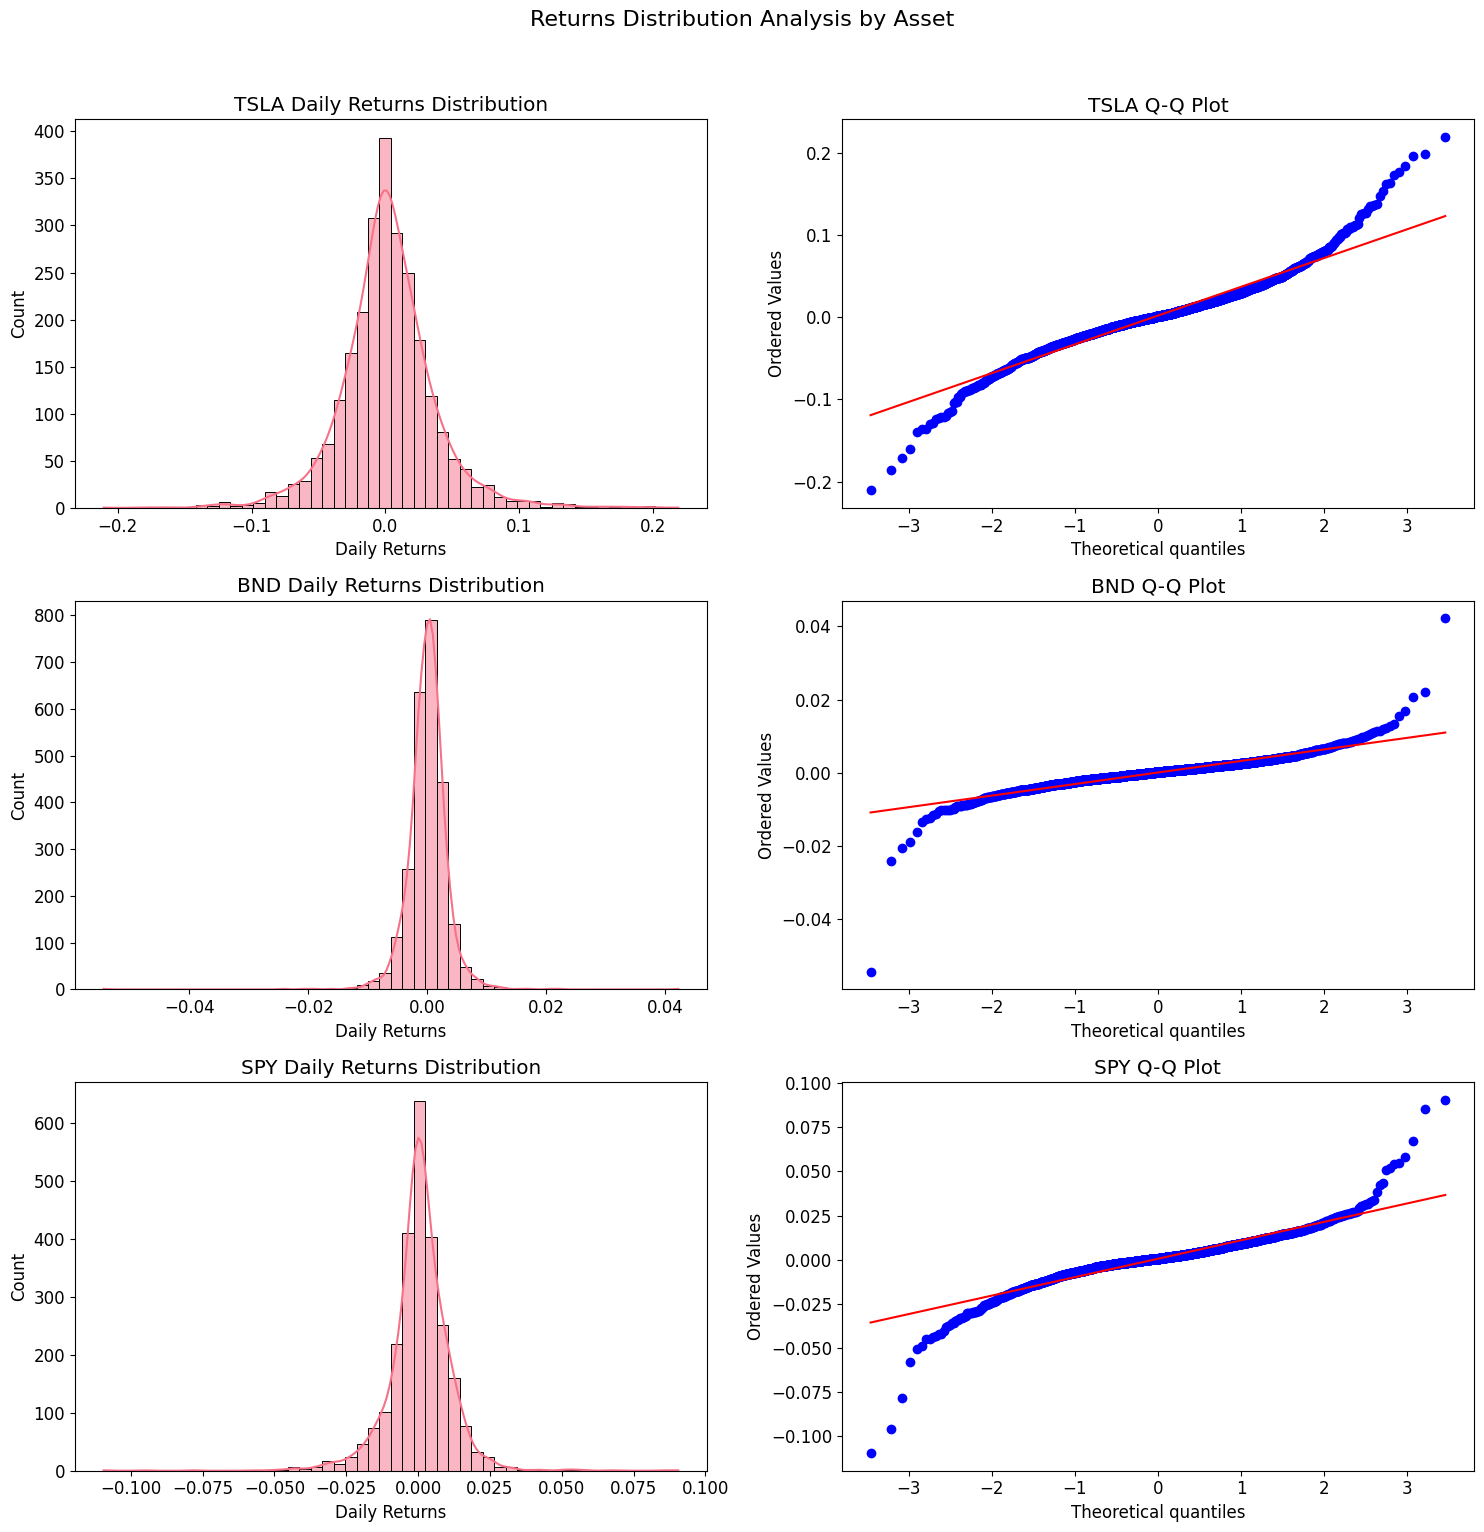

In [15]:
# 2. Returns Distribution Analysis
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Returns Distribution Analysis by Asset', fontsize=16, y=1.02)

for idx, (ticker, data) in enumerate(processed_data.items()):
    # Histogram of returns
    sns.histplot(data=data['Daily_Return'].dropna(), kde=True, bins=50, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{ticker} Daily Returns Distribution')
    axes[idx, 0].set_xlabel('Daily Returns')
    
    # Q-Q plot
    stats.probplot(data['Daily_Return'].dropna(), dist="norm", plot=axes[idx, 1])
    axes[idx, 1].set_title(f'{ticker} Q-Q Plot')

plt.tight_layout()
plt.show()

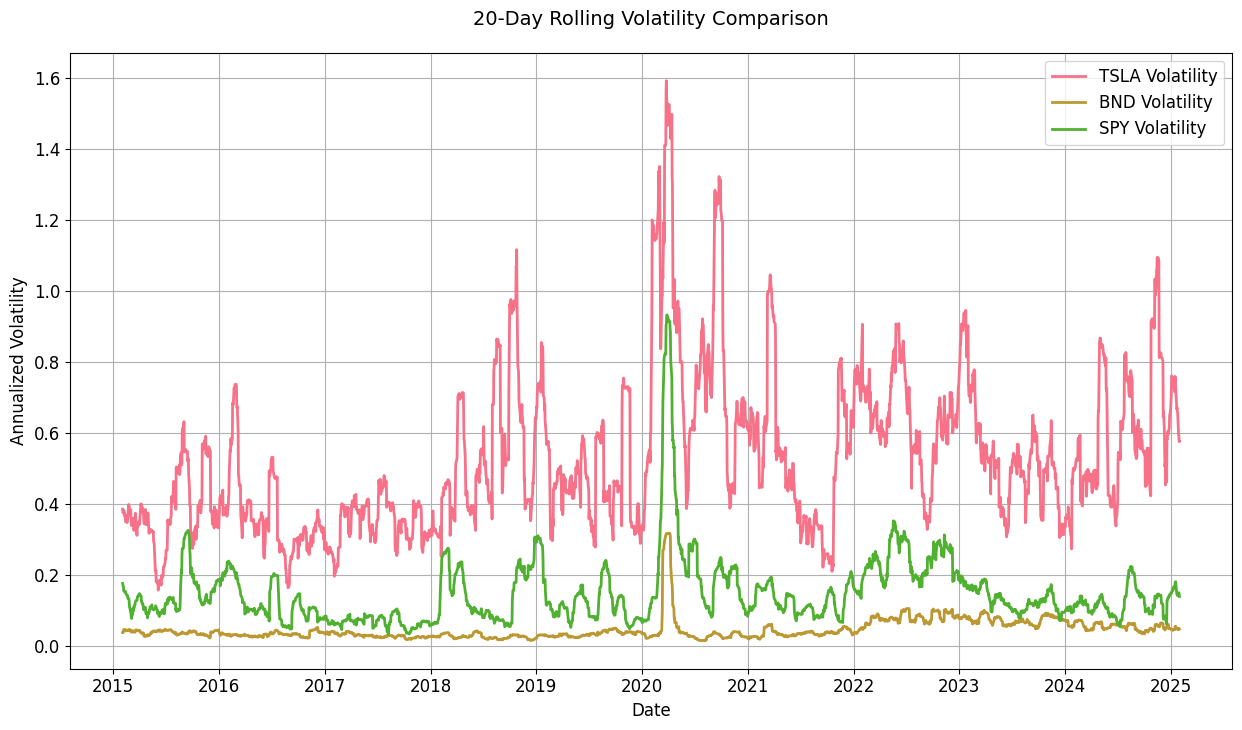

In [16]:
# 3. Volatility Analysis
plt.figure(figsize=(15, 8))
for ticker, data in processed_data.items():
    plt.plot(data.index, data['Volatility'], label=f'{ticker} Volatility', linewidth=2)
plt.title('20-Day Rolling Volatility Comparison', fontsize=14, pad=20)
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True)
plt.show()

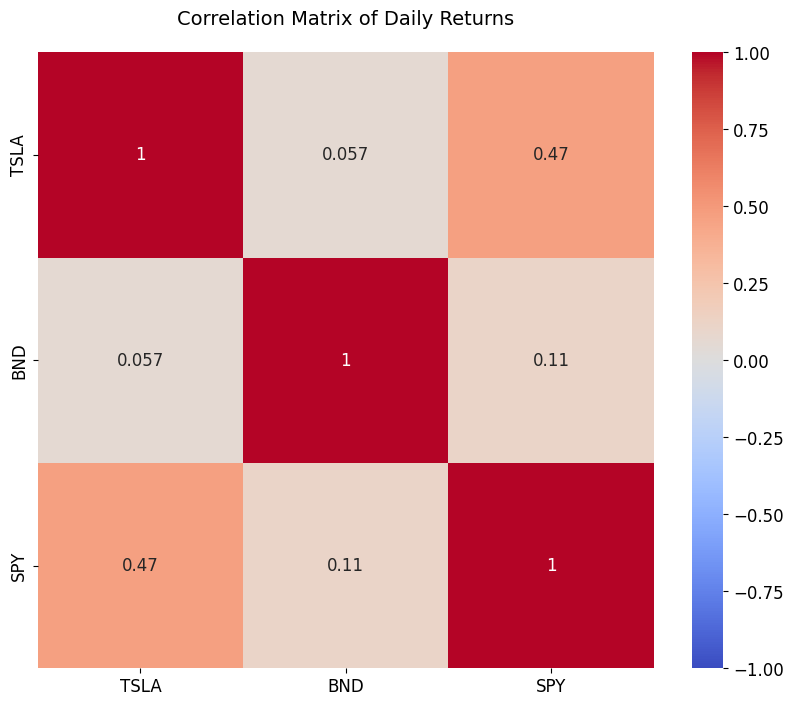

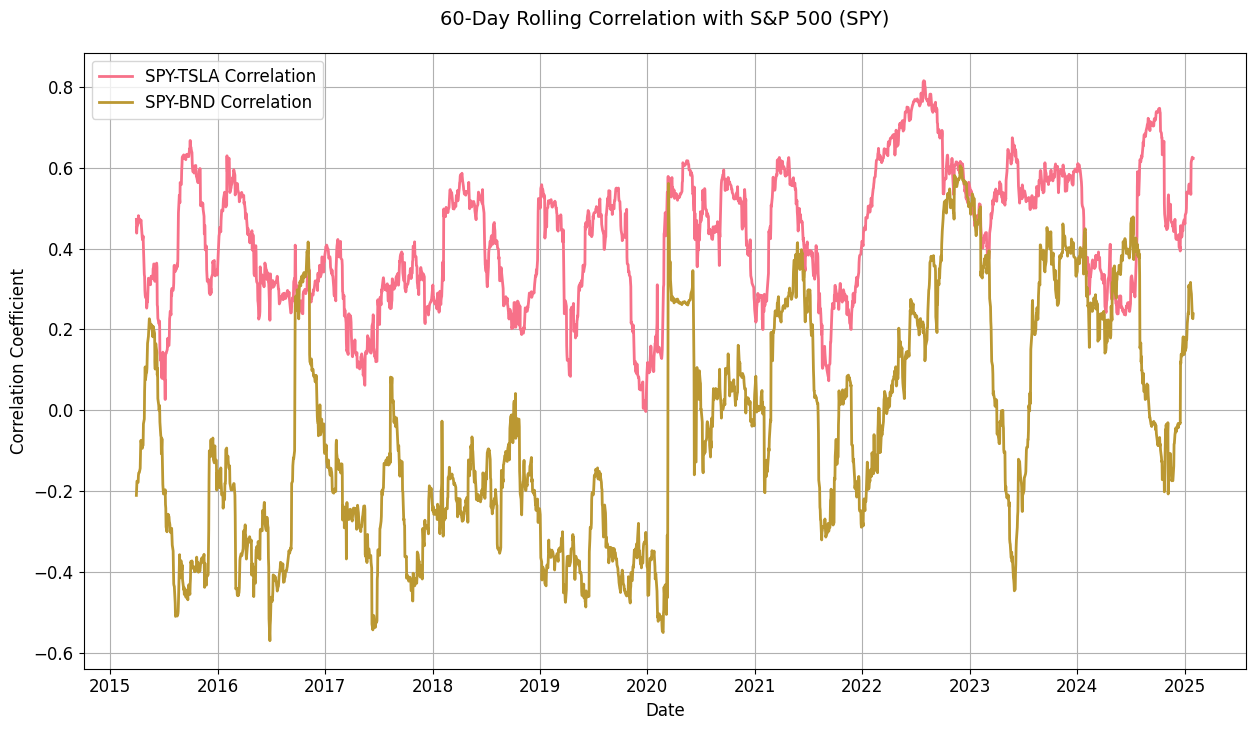

In [17]:
# 4. Correlation Analysis
# Calculate correlation matrix of daily returns
returns_df = pd.DataFrame({ticker: data['Daily_Return'] 
                          for ticker, data in processed_data.items()})
correlation_matrix = returns_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, square=True)
plt.title('Correlation Matrix of Daily Returns', fontsize=14, pad=20)
plt.show()

# 5. Rolling Correlation Analysis
plt.figure(figsize=(15, 8))
# Calculate 60-day rolling correlation between SPY and other assets
for ticker in ['TSLA', 'BND']:
    roll_corr = returns_df['SPY'].rolling(60).corr(returns_df[ticker])
    plt.plot(returns_df.index, roll_corr, label=f'SPY-{ticker} Correlation', linewidth=2)
plt.title('60-Day Rolling Correlation with S&P 500 (SPY)', fontsize=14, pad=20)
plt.xlabel('Date')
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.grid(True)
plt.show()

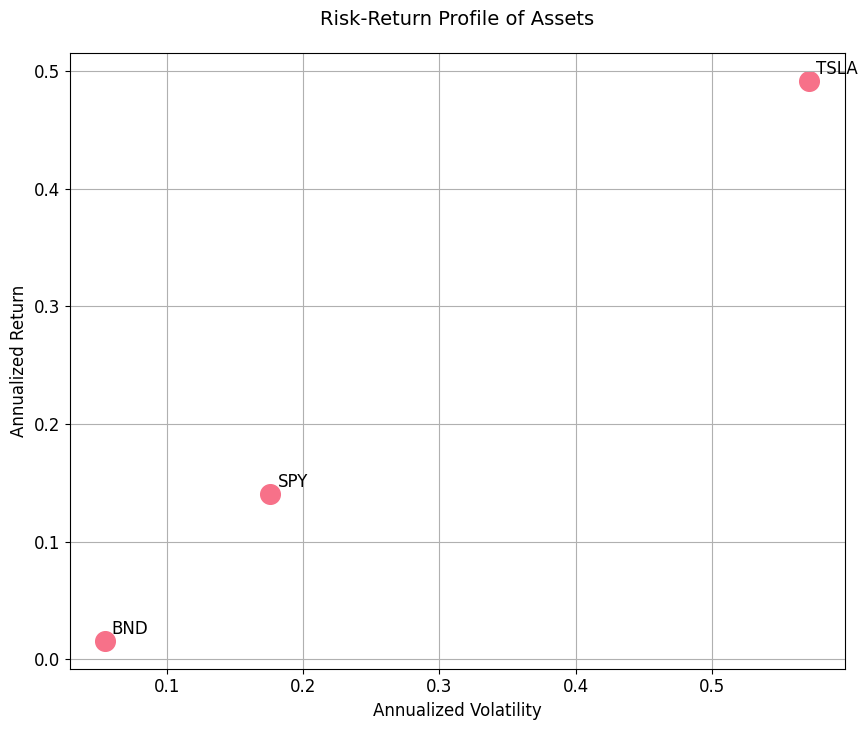

In [18]:
# 6. Risk-Return Analysis
annual_returns = {ticker: data['Daily_Return'].mean() * 252 
                 for ticker, data in processed_data.items()}
annual_volatility = {ticker: data['Daily_Return'].std() * np.sqrt(252) 
                    for ticker, data in processed_data.items()}

plt.figure(figsize=(10, 8))
plt.scatter(annual_volatility.values(), annual_returns.values(), s=200)
for ticker in processed_data.keys():
    plt.annotate(ticker, (annual_volatility[ticker], annual_returns[ticker]), 
                xytext=(5, 5), textcoords='offset points')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.title('Risk-Return Profile of Assets', fontsize=14, pad=20)
plt.grid(True)
plt.show()


In [19]:
# 7. Summary Statistics Table
summary_all = pd.DataFrame()
for ticker, data in processed_data.items():
    stats = pd.Series({
        'Mean Daily Return': f"{data['Daily_Return'].mean():.4f}",
        'Annualized Return': f"{data['Daily_Return'].mean() * 252:.4f}",
        'Daily Volatility': f"{data['Daily_Return'].std():.4f}",
        'Annualized Volatility': f"{data['Daily_Return'].std() * np.sqrt(252):.4f}",
        'Sharpe Ratio': f"{metrics.calculate_sharpe_ratio(data['Daily_Return']):.4f}",
        'VaR (95%)': f"{metrics.calculate_var(data['Daily_Return']):.4f}",
        'Maximum Drawdown': f"{(data['Close'] / data['Close'].cummax() - 1).min():.4f}",
        'Skewness': f"{data['Daily_Return'].skew():.4f}",
        'Kurtosis': f"{data['Daily_Return'].kurtosis():.4f}"
    })
    summary_all[ticker] = stats

display(summary_all)

,TSLA,BND,SPY
Mean Daily Return,0.0020,0.0001,0.0006
Annualized Return,0.4919,0.0157,0.1403
Daily Volatility,0.0360,0.0034,0.0111
Annualized Volatility,0.5716,0.0544,0.1759
Sharpe Ratio,0.8257,-0.0787,0.6838
VaR (95%),-0.0514,-0.0048,-0.0167
Maximum Drawdown,-0.7363,-0.1858,-0.3372
Skewness,0.2797,-0.9471,-0.5550
Kurtosis,4.3663,37.7352,12.7341


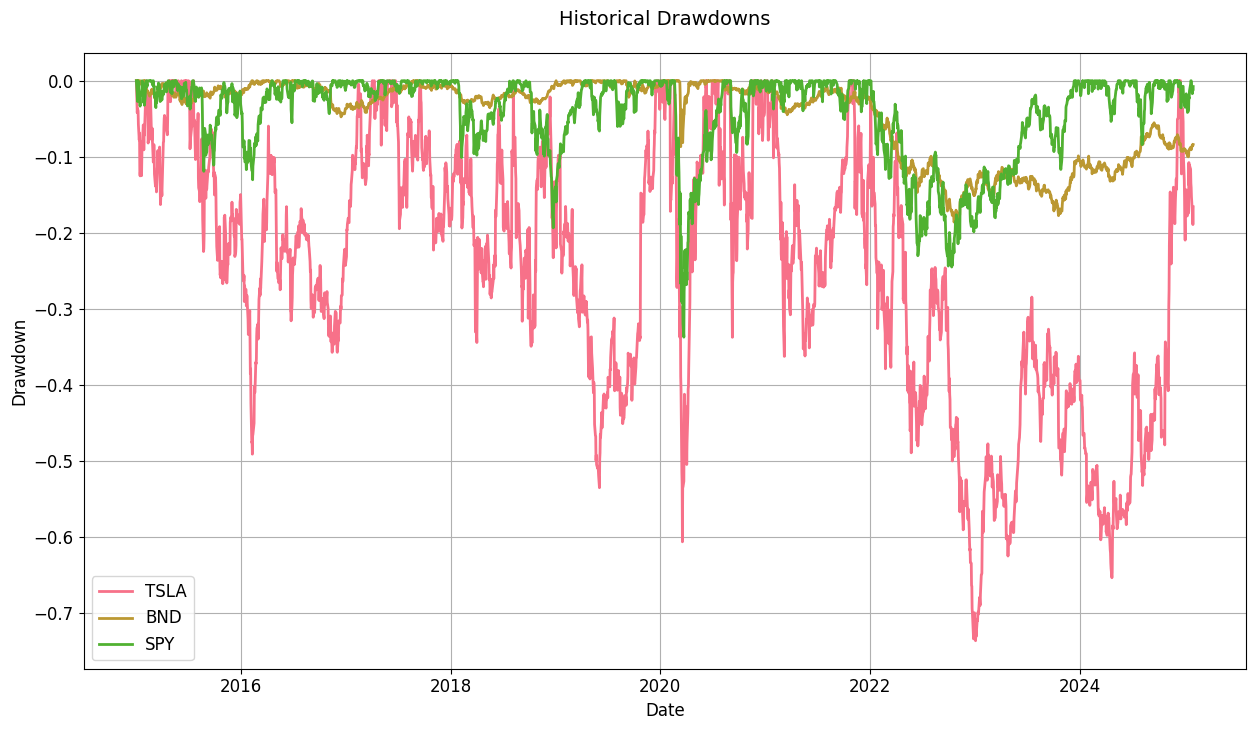

In [20]:
# 8. Drawdown Analysis
plt.figure(figsize=(15, 8))
for ticker, data in processed_data.items():
    drawdown = data['Close'] / data['Close'].cummax() - 1
    plt.plot(data.index, drawdown, label=ticker, linewidth=2)
plt.title('Historical Drawdowns', fontsize=14, pad=20)
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
# Print significant events for each asset
for ticker, data in processed_data.items():
    print(f"\nMost Significant Price Movements for {ticker}:")
    significant_moves = pd.concat([
        data['Daily_Return'].nlargest(5),
        data['Daily_Return'].nsmallest(5)
    ]).sort_values(ascending=False)
    
    for date, ret in significant_moves.items():
        print(f"{date.strftime('%Y-%m-%d')}: {ret:.2%}")


Most Significant Price Movements for TSLA:
2024-10-24: 21.92%
2020-02-03: 19.89%
2021-03-09: 19.64%
2020-03-19: 18.39%
2019-10-24: 17.67%
2018-09-28: -13.90%
2020-03-18: -16.03%
2020-02-05: -17.18%
2020-03-16: -18.58%
2020-09-08: -21.06%

Most Significant Price Movements for BND:
2020-03-13: 4.22%
2020-03-23: 2.21%
2022-11-10: 2.07%
2020-03-20: 1.70%
2022-09-28: 1.55%
2022-06-13: -1.62%
2020-03-11: -1.89%
2020-03-17: -2.07%
2020-03-18: -2.41%
2020-03-12: -5.44%

Most Significant Price Movements for SPY:
2020-03-24: 9.06%
2020-03-13: 8.55%
2020-04-06: 6.72%
2020-03-26: 5.84%
2022-11-10: 5.50%
2020-03-18: -5.06%
2020-06-11: -5.76%
2020-03-09: -7.81%
2020-03-12: -9.57%
2020-03-16: -10.94%


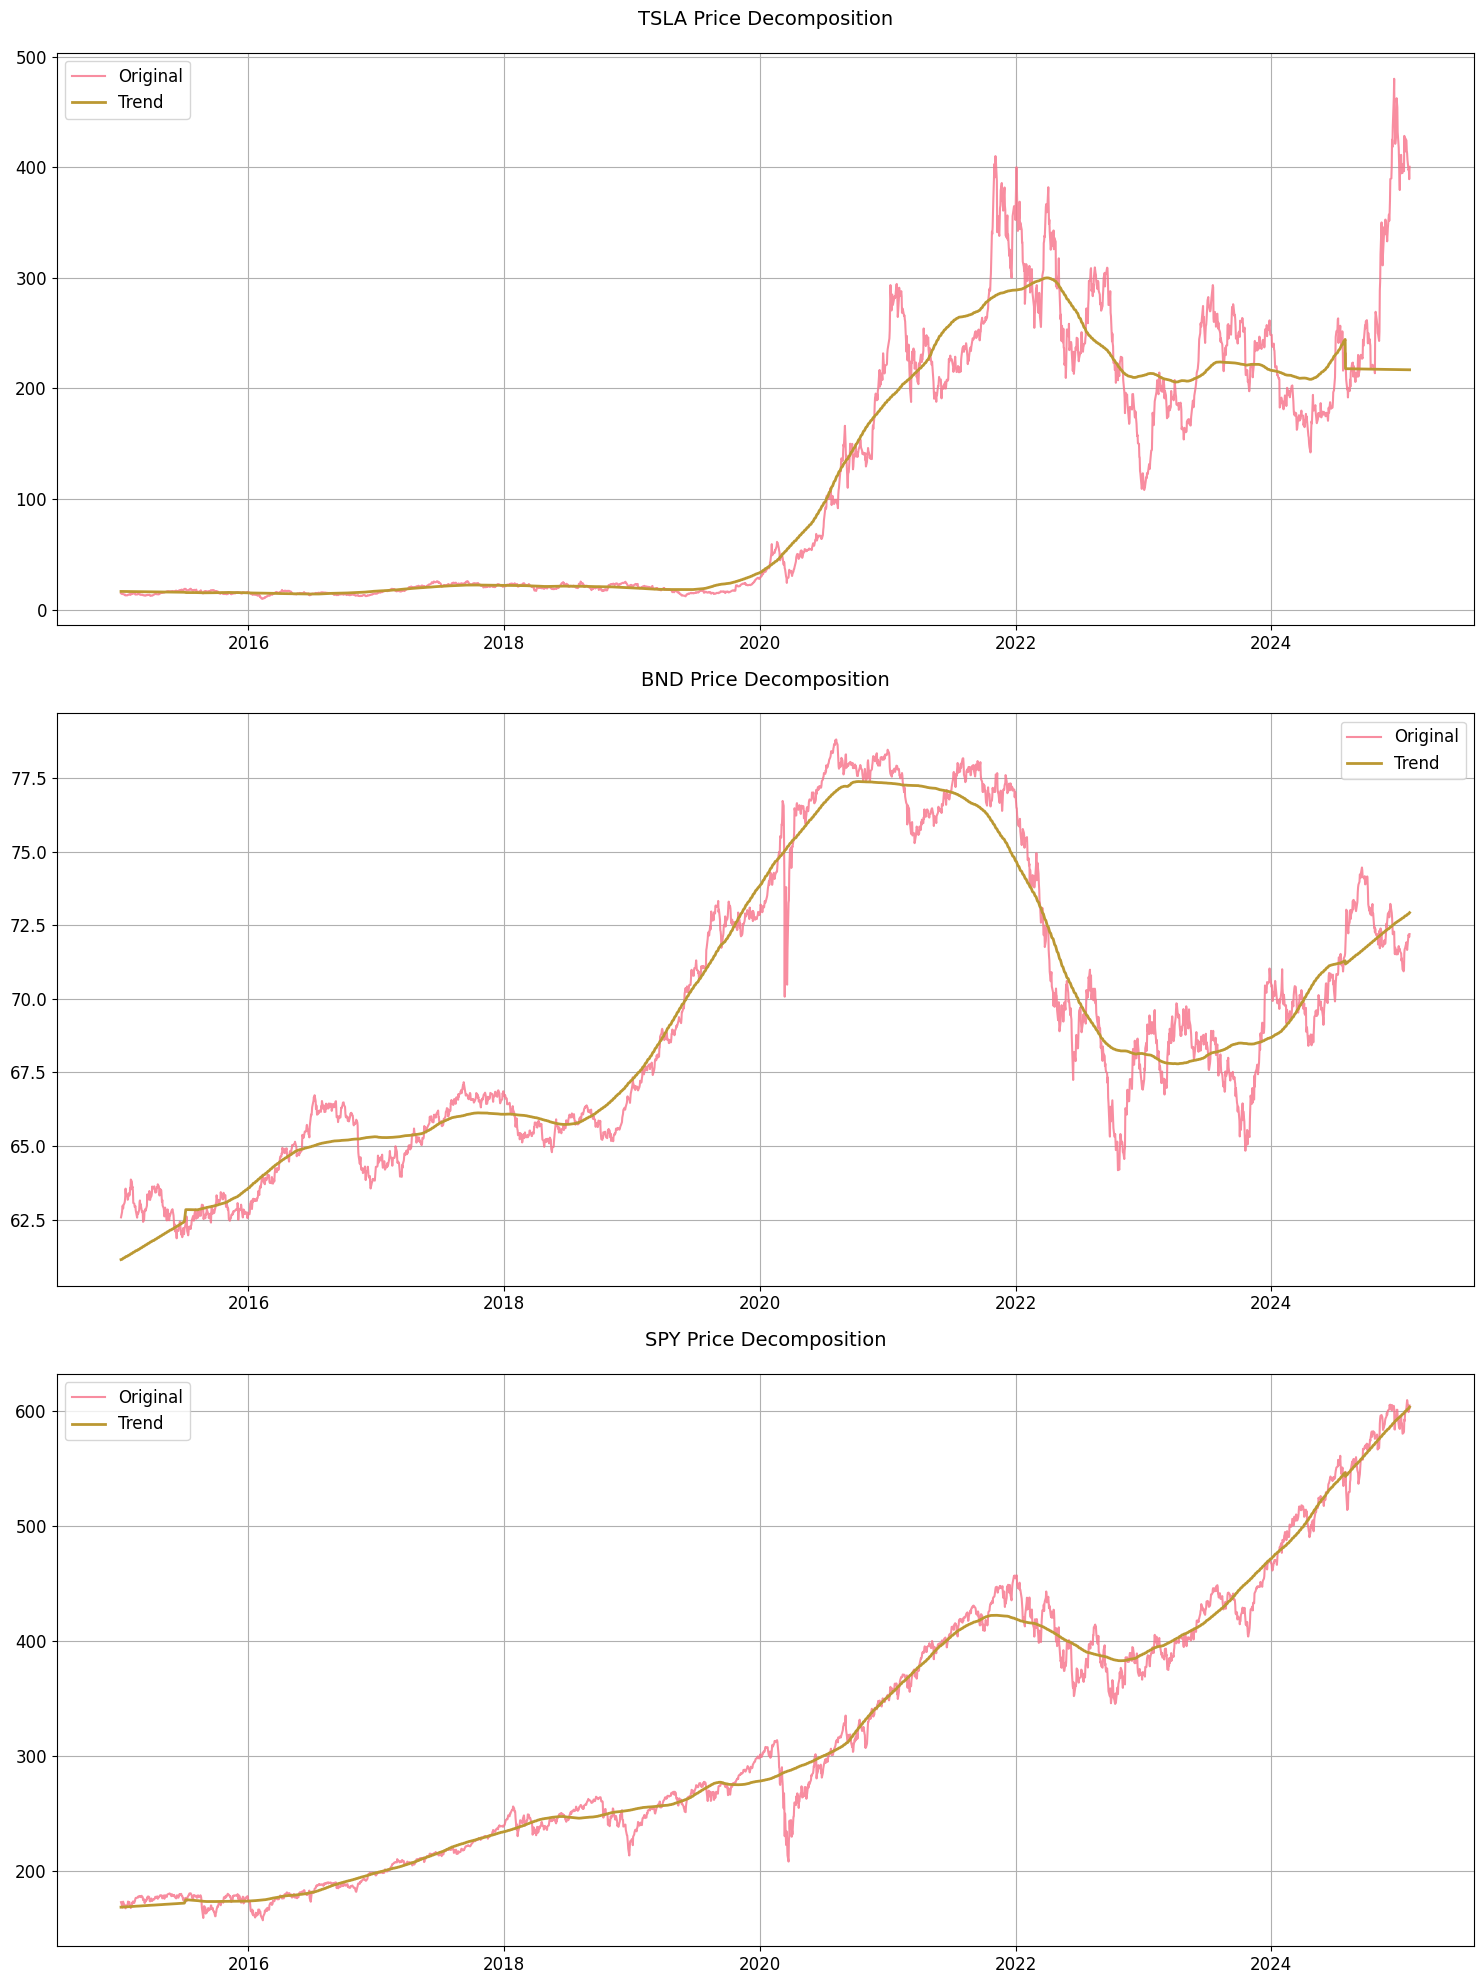

In [22]:
# 9. Seasonality and Trend Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

plt.figure(figsize=(15, 20))
for idx, (ticker, data) in enumerate(processed_data.items()):
    # Perform decomposition on closing prices
    decomposition = seasonal_decompose(data['Close'], 
                                     period=252,  # Using 252 trading days as period
                                     extrapolate_trend='freq')
    
    # Plot decomposition
    plt.subplot(3, 1, idx + 1)
    
    # Original
    plt.plot(data.index, decomposition.observed, label='Original', alpha=0.8)
    plt.plot(data.index, decomposition.trend, label='Trend', linewidth=2)
    plt.title(f'{ticker} Price Decomposition', fontsize=14, pad=20)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [23]:
# 10. Seasonal Statistics Table
seasonal_stats = pd.DataFrame()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for ticker, data in processed_data.items():
    monthly_stats = data['Daily_Return'].groupby(data.index.month).agg([
        'mean', 'std', 'count'
    ])
    monthly_stats['sharpe'] = monthly_stats['mean'] / monthly_stats['std']
    monthly_stats.index = months
    
    stats = pd.Series({
        'Best Month': f"{months[monthly_stats['mean'].argmax()]} ({monthly_stats['mean'].max():.2%})",
        'Worst Month': f"{months[monthly_stats['mean'].argmin()]} ({monthly_stats['mean'].min():.2%})",
        'Most Volatile Month': f"{months[monthly_stats['std'].argmax()]} ({monthly_stats['std'].max():.2%})",
        'Best Risk-Adjusted Month': f"{months[monthly_stats['sharpe'].argmax()]} ({monthly_stats['sharpe'].max():.2f})"
    })
    seasonal_stats[ticker] = stats

display(seasonal_stats)

,TSLA,BND,SPY
Best Month,Jun (0.53%),Jul (0.04%),Nov (0.21%)
Worst Month,Mar (-0.07%),Sep (-0.04%),Sep (-0.09%)
Most Volatile Month,Mar (4.29%),Mar (0.67%),Mar (1.98%)
Best Risk-Adjusted Month,Jun (0.17),Jul (0.17),Jul (0.23)


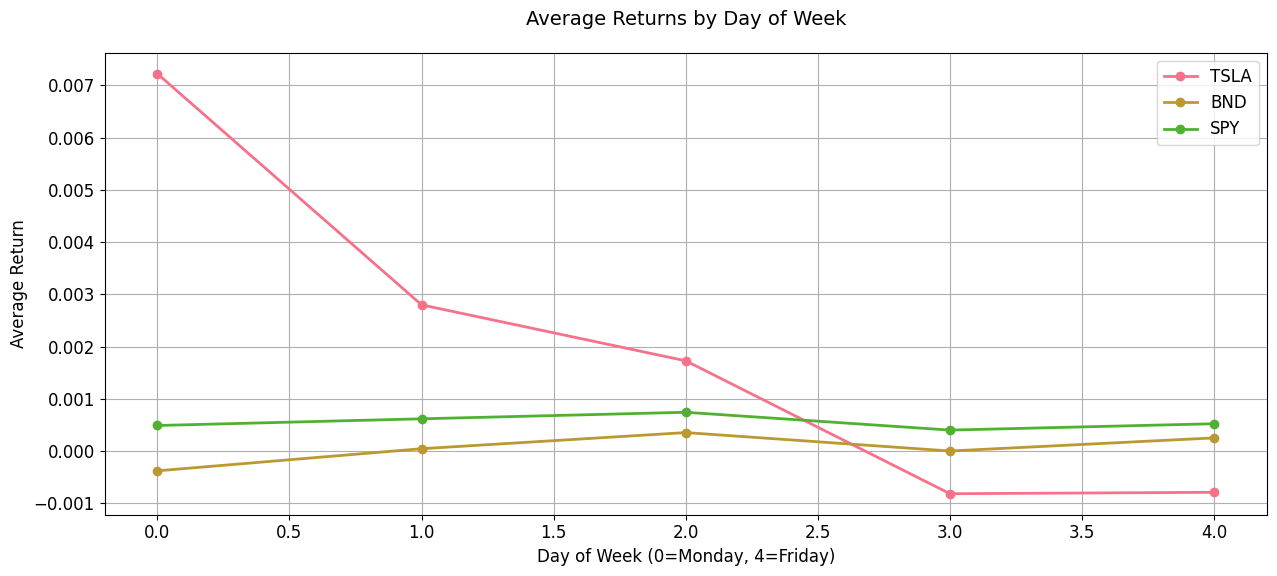

In [24]:
# 11. Day-of-Week Effect
plt.figure(figsize=(15, 6))
for ticker, data in processed_data.items():
    daily_returns = data['Daily_Return'].groupby(data.index.dayofweek).mean()
    plt.plot(daily_returns.index, daily_returns, 
             marker='o', label=ticker, linewidth=2)

plt.title('Average Returns by Day of Week', fontsize=14, pad=20)
plt.xlabel('Day of Week (0=Monday, 4=Friday)')
plt.ylabel('Average Return')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Print key seasonal findings
for ticker, data in processed_data.items():
    print(f"\nSeasonal Patterns for {ticker}:")
    
    # Monthly analysis
    monthly_returns = data['Daily_Return'].groupby(data.index.month).mean() * 100
    best_month = months[monthly_returns.argmax()]
    worst_month = months[monthly_returns.argmin()]
    print(f"Best Month: {best_month} ({monthly_returns.max():.2f}%)")
    print(f"Worst Month: {worst_month} ({monthly_returns.min():.2f}%)")
    
    # Day of week analysis
    daily_returns = data['Daily_Return'].groupby(data.index.dayofweek).mean() * 100
    best_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'][daily_returns.argmax()]
    worst_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'][daily_returns.argmin()]
    print(f"Best Day: {best_day} ({daily_returns.max():.2f}%)")
    print(f"Worst Day: {worst_day} ({daily_returns.min():.2f}%)")


Seasonal Patterns for TSLA:
Best Month: Jun (0.53%)
Worst Month: Mar (-0.07%)
Best Day: Monday (0.72%)
Worst Day: Thursday (-0.08%)

Seasonal Patterns for BND:
Best Month: Jul (0.04%)
Worst Month: Sep (-0.04%)
Best Day: Wednesday (0.04%)
Worst Day: Monday (-0.04%)

Seasonal Patterns for SPY:
Best Month: Nov (0.21%)
Worst Month: Sep (-0.09%)
Best Day: Wednesday (0.07%)
Worst Day: Thursday (0.04%)


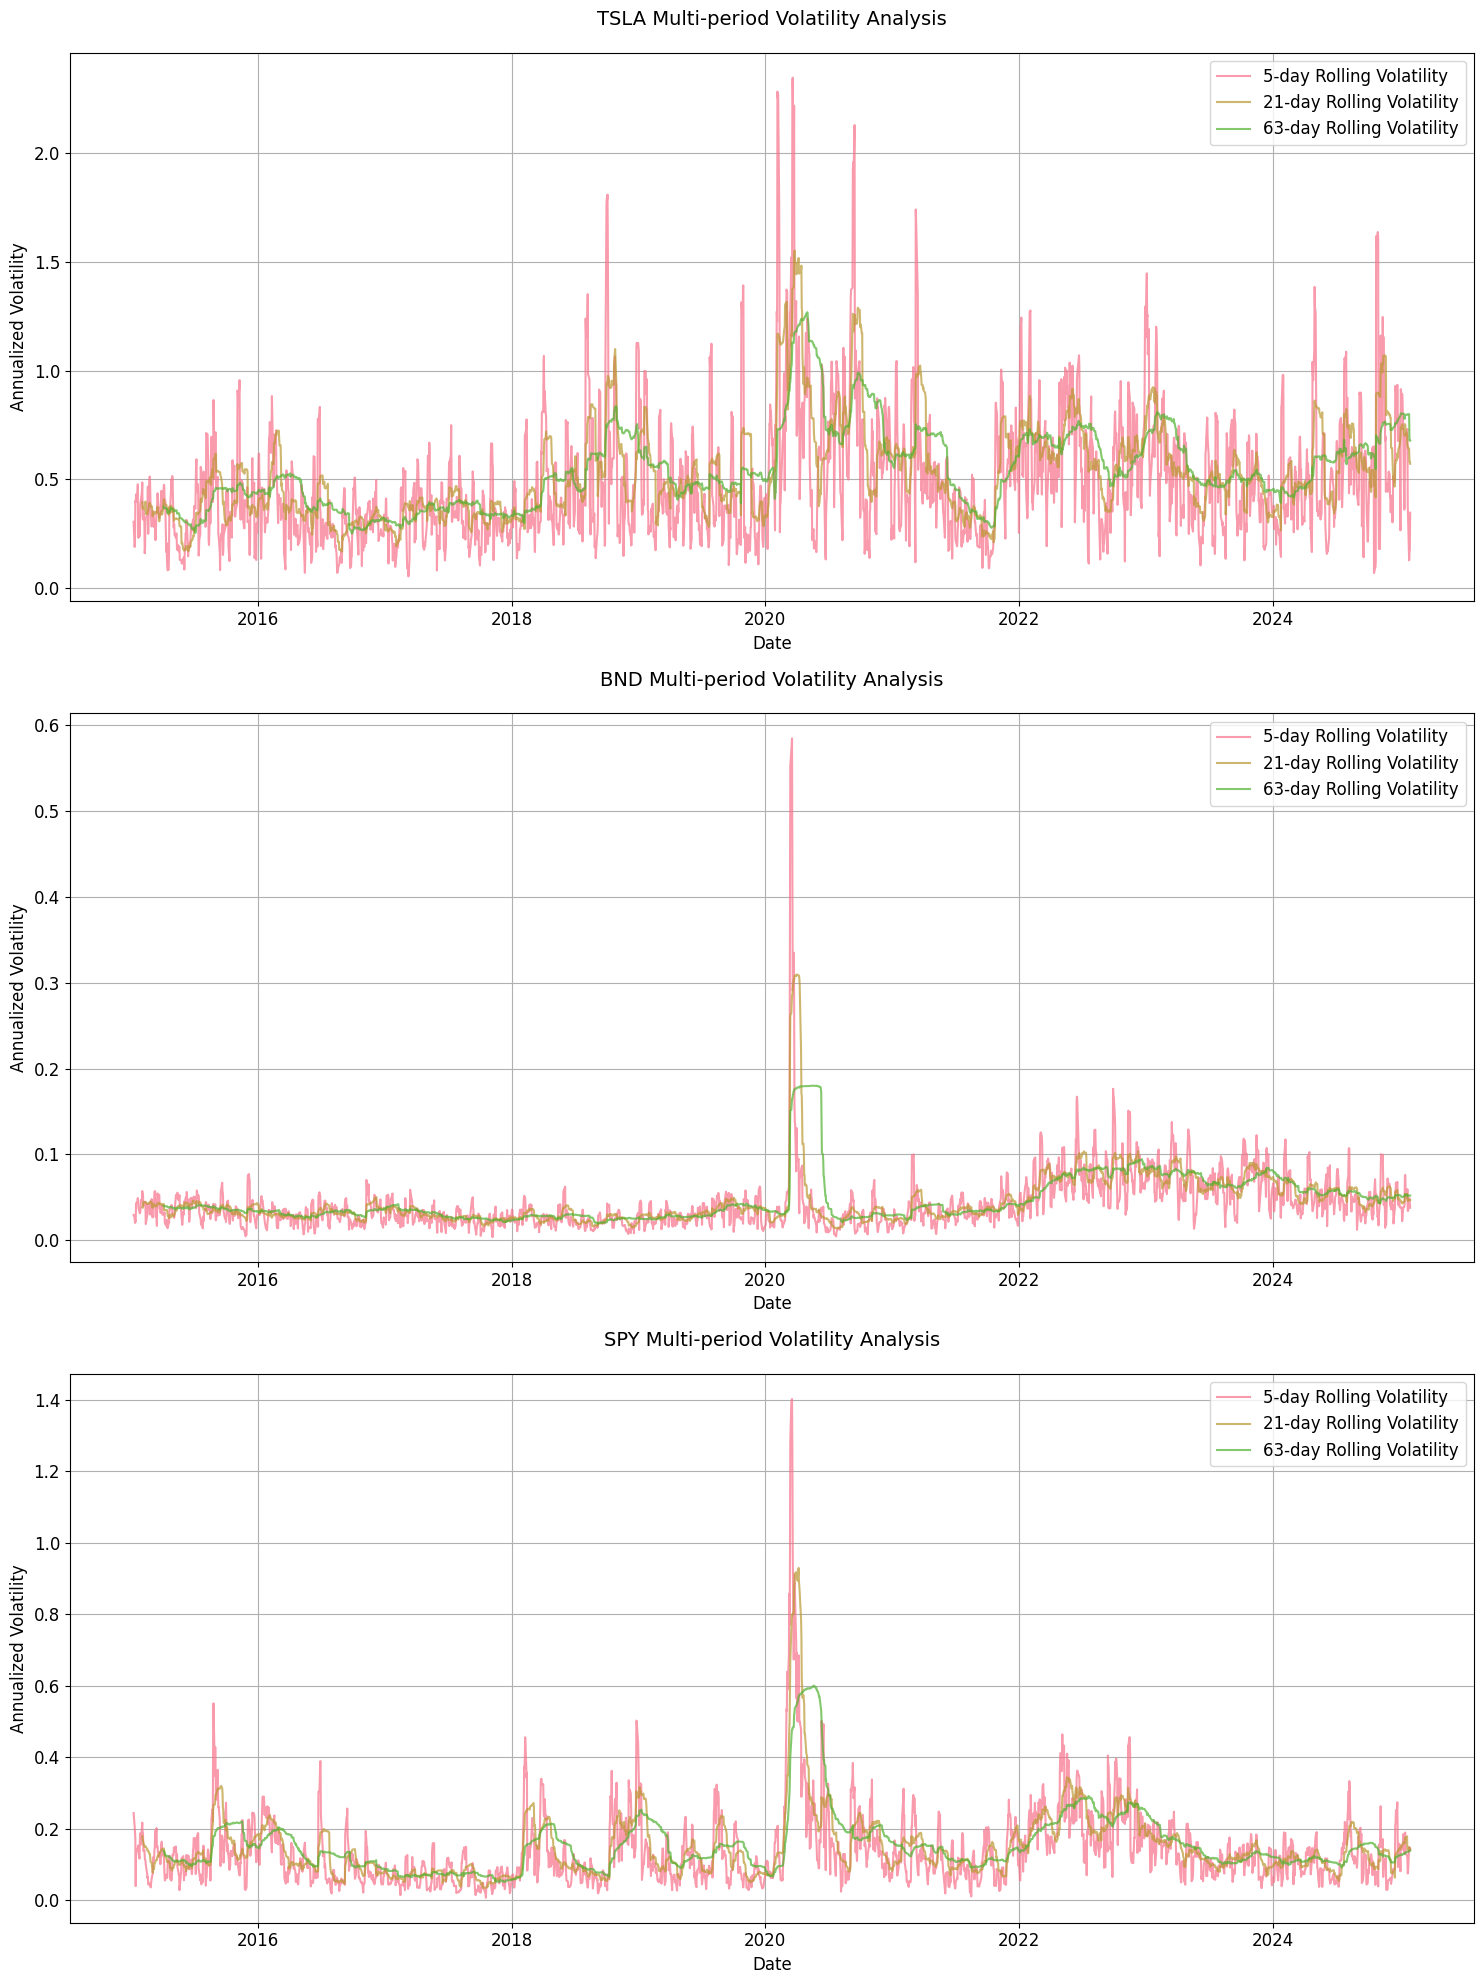

In [26]:
# 12. Comprehensive Volatility Analysis
plt.figure(figsize=(15, 20))

# Rolling statistics windows
windows = [5, 21, 63]  # 1 week, 1 month, 3 months

for idx, (ticker, data) in enumerate(processed_data.items()):
    plt.subplot(3, 1, idx + 1)
    
    # Plot different rolling volatility windows
    for window in windows:
        roll_vol = data['Daily_Return'].rolling(window=window).std() * np.sqrt(252)
        plt.plot(data.index, roll_vol, 
                label=f'{window}-day Rolling Volatility', 
                alpha=0.7)
    
    plt.title(f'{ticker} Multi-period Volatility Analysis', fontsize=14, pad=20)
    plt.xlabel('Date')
    plt.ylabel('Annualized Volatility')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

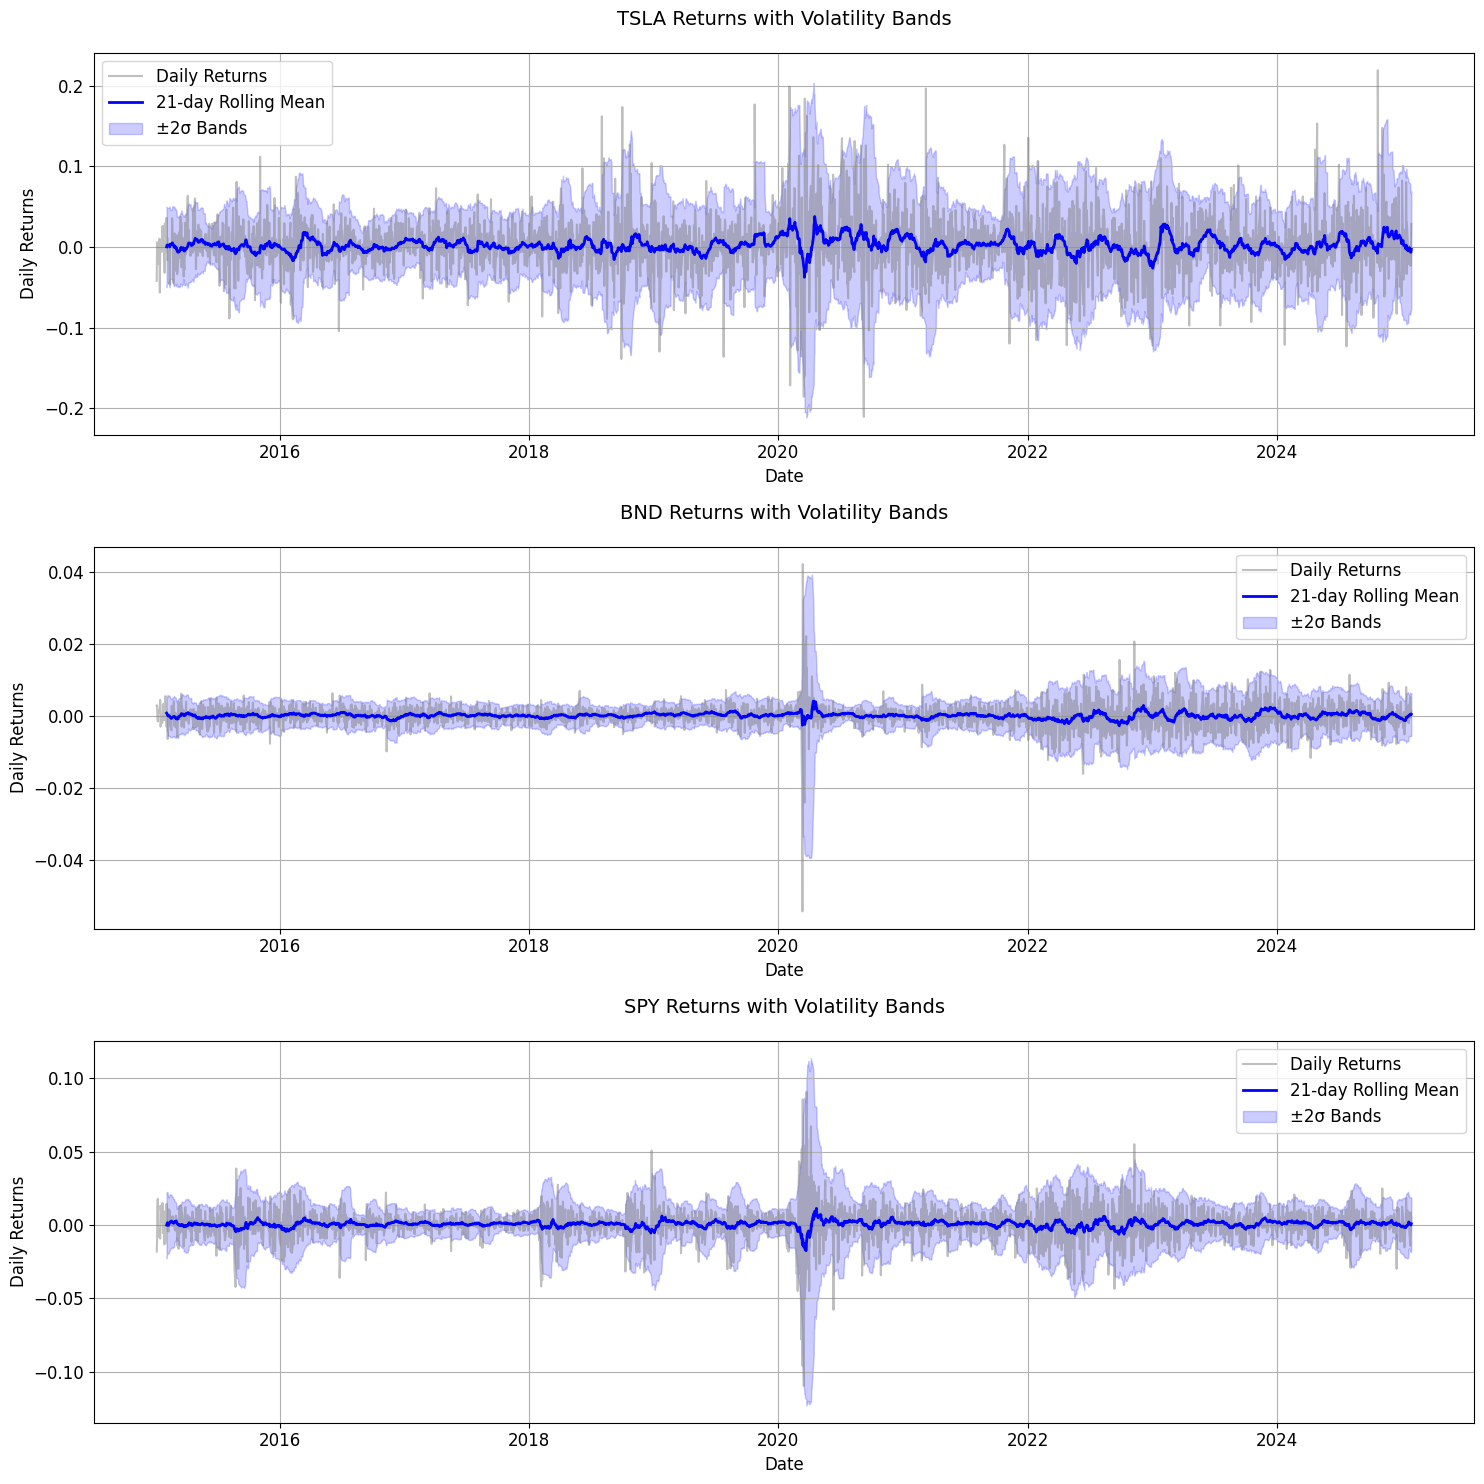

In [27]:
# 13. Volatility Regime Analysis
plt.figure(figsize=(15, 15))

for idx, (ticker, data) in enumerate(processed_data.items()):
    plt.subplot(3, 1, idx + 1)
    
    # Calculate rolling mean and std of returns
    roll_mean = data['Daily_Return'].rolling(window=21).mean()
    roll_std = data['Daily_Return'].rolling(window=21).std()
    
    # Plot returns with rolling mean and confidence bands
    plt.plot(data.index, data['Daily_Return'], 
             label='Daily Returns', alpha=0.5, color='gray')
    plt.plot(data.index, roll_mean, 
             label='21-day Rolling Mean', color='blue', linewidth=2)
    plt.fill_between(data.index, 
                     roll_mean - 2*roll_std, 
                     roll_mean + 2*roll_std,
                     alpha=0.2, color='blue',
                     label='±2σ Bands')
    
    plt.title(f'{ticker} Returns with Volatility Bands', fontsize=14, pad=20)
    plt.xlabel('Date')
    plt.ylabel('Daily Returns')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [30]:
# 14. Key Volatility Metrics and Insights
volatility_insights = pd.DataFrame()
fin_metrics = FinancialMetrics()  # Create instance of FinancialMetrics

for ticker, data in processed_data.items():
    # Calculate various volatility metrics
    daily_returns = data['Daily_Return']
    
    # Basic volatility metrics
    annual_vol = daily_returns.std() * np.sqrt(252)
    vol_of_vol = daily_returns.rolling(window=21).std().std() * np.sqrt(252)
    
    # Upside/Downside volatility
    upside_returns = daily_returns[daily_returns > 0]
    downside_returns = daily_returns[daily_returns < 0]
    upside_vol = upside_returns.std() * np.sqrt(252)
    downside_vol = downside_returns.std() * np.sqrt(252)
    
    # Volatility regimes
    high_vol_days = (daily_returns.abs() > 2 * daily_returns.std()).sum()
    pct_high_vol = high_vol_days / len(daily_returns)
    
    # Maximum drawdown calculation
    rolling_max = data['Close'].expanding().max()
    drawdown = (data['Close'] - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    # Compile insights
    stats = pd.Series({
        'Annualized Volatility': f"{annual_vol:.4f}",
        'Volatility of Volatility': f"{vol_of_vol:.4f}",
        'Upside Volatility': f"{upside_vol:.4f}",
        'Downside Volatility': f"{downside_vol:.4f}",
        'High Volatility Days (%)': f"{pct_high_vol:.2%}",
        'Maximum Drawdown': f"{max_drawdown:.2%}",
        'Sharpe Ratio': f"{fin_metrics.calculate_sharpe_ratio(daily_returns):.4f}",
        'VaR (95%)': f"{fin_metrics.calculate_var(daily_returns):.4f}"
    })
    
    volatility_insights[ticker] = stats

display(volatility_insights)

,TSLA,BND,SPY
Annualized Volatility,0.5716,0.0544,0.1759
Volatility of Volatility,0.2184,0.0310,0.0973
Upside Volatility,0.4300,0.0386,0.1213
Downside Volatility,0.3880,0.0437,0.1453
High Volatility Days (%),5.60%,3.87%,4.69%
Maximum Drawdown,-73.63%,-18.58%,-33.72%
Sharpe Ratio,0.8257,-0.0787,0.6838
VaR (95%),-0.0514,-0.0048,-0.0167


In [31]:
# Print detailed insights for each asset
for ticker, data in processed_data.items():
    print(f"\nKey Volatility Insights for {ticker}:")
    
    # Overall trend
    total_return = (data['Close'][-1] / data['Close'][0] - 1) * 100
    print(f"Overall Price Direction: {total_return:.2f}% total return")
    
    # Volatility characteristics
    vol_metrics = volatility_insights[ticker]
    print(f"Risk Profile:")
    print(f"- Annualized Volatility: {vol_metrics['Annualized Volatility']}")
    print(f"- Sharpe Ratio: {vol_metrics['Sharpe Ratio']}")
    print(f"- VaR (95%): {vol_metrics['VaR (95%)']}")
    
    # Volatility regimes
    high_vol_periods = data[data['Volatility'] > data['Volatility'].mean() + \
                           data['Volatility'].std()]
    print("\nVolatility Regimes:")
    print(f"- High Volatility Days: {vol_metrics['High Volatility Days (%)']}")
    print(f"- Upside/Downside Vol Ratio: " \
          f"{float(vol_metrics['Upside Volatility'])/float(vol_metrics['Downside Volatility']):.2f}")
    
    # Maximum drawdown period
    rolling_max = data['Close'].expanding().max()
    drawdown = (data['Close'] - rolling_max) / rolling_max
    max_dd_idx = drawdown.idxmin()
    print("\nMaximum Drawdown Period:")
    print(f"- Maximum Drawdown: {vol_metrics['Maximum Drawdown']}")
    print(f"- Occurred on: {max_dd_idx.strftime('%Y-%m-%d')}")


Key Volatility Insights for TSLA:
Overall Price Direction: 2637.77% total return
Risk Profile:
- Annualized Volatility: 0.5716
- Sharpe Ratio: 0.8257
- VaR (95%): -0.0514

Volatility Regimes:
- High Volatility Days: 5.60%
- Upside/Downside Vol Ratio: 1.11

Maximum Drawdown Period:
- Maximum Drawdown: -73.63%
- Occurred on: 2023-01-03

Key Volatility Insights for BND:
Overall Price Direction: 15.39% total return
Risk Profile:
- Annualized Volatility: 0.0544
- Sharpe Ratio: -0.0787
- VaR (95%): -0.0048

Volatility Regimes:
- High Volatility Days: 3.87%
- Upside/Downside Vol Ratio: 0.88

Maximum Drawdown Period:
- Maximum Drawdown: -18.58%
- Occurred on: 2022-10-20

Key Volatility Insights for SPY:
Overall Price Direction: 250.56% total return
Risk Profile:
- Annualized Volatility: 0.1759
- Sharpe Ratio: 0.6838
- VaR (95%): -0.0167

Volatility Regimes:
- High Volatility Days: 4.69%
- Upside/Downside Vol Ratio: 0.83

Maximum Drawdown Period:
- Maximum Drawdown: -33.72%
- Occurred on: 2020